# 1만곡의 아이돌 가사 토픽모델링 해보기 (LDA)

LDA코드(Topic Modeling with Gensim) 참고 http://www.engear.net/wp/topic-modeling-gensimpython/

In [533]:
#!pip install wordcloud
#!pip install pyLDAvis

In [534]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
 
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from konlpy.tag import Twitter
twitter = Twitter()
 
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
 
 
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
 
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [205]:
# Import Dataset
df = pd.read_csv("data/song_tidy03.csv")
df.head()

,title,artist,album,release_date,song_genre,is_title,like,creator,lyrics,lyricist,composer,arranger
0,latata,(여자)아이들,I am,2018.05.02,Dance,타이틀 곡,"85,374",소연 작사 소연 작곡 빅싼초 (Yummy Tone) 작곡 빅싼...,기나긴 너와 이 밤을<br>너와 이렇게 너와<br>기다린 너와 시간을<br>너와 이...,소연,"소연, 빅싼초 (Yummy Tone)","빅싼초 (Yummy Tone), 소연"
1,달라($$$),(여자)아이들,I am,2018.05.02,Dance,수록곡,"4,229",Le`mon 작사 소연 작사 윤종성 작곡 Le`mon 작곡...,Knock knock 들어간다<br>Soyeon이<br>머리 위에 Spotlight...,"Le`mon, 소연","윤종성, Le`mon",윤종성
2,maze,(여자)아이들,I am,2018.05.02,Dance,수록곡,"6,198",ZeroZine (MosPick) 작사 Ferdy (MosPick) 작사...,너의 깊은 그 눈빛이<br>날 데려가 저 멀리<br>누군가 맘에 들 때<br>더 신...,"ZeroZine (MosPick), Ferdy (MosPick), 소연","ZeroZine (MosPick), Ferdy (MosPick)","ZeroZine (MosPick), Ferdy (MosPick)"
3,don`ttextme,(여자)아이들,I am,2018.05.02,Dance,수록곡,"2,950",빅싼초 (Yummy Tone) 작사 박해일 (Yummy Tone) 작사 ...,오늘따라 이상하리만큼<br>잠이 오지 않아 괜히 뒤척여<br>익숙한 듯 어떻게 연락...,"빅싼초 (Yummy Tone), 박해일 (Yummy Tone), 재리포터, 소연","빅싼초 (Yummy Tone), 박해일 (Yummy Tone), 재리포터","빅싼초 (Yummy Tone), 박해일 (Yummy Tone)"
4,알고싶어,(여자)아이들,I am,2018.05.02,Dance,수록곡,"3,384",ARIN 작사 VINCENZO 작사 Fuxxy 작사 Any M...,What's in your house<br>What's in your house<b...,"ARIN, VINCENZO, Fuxxy, Any Masingga, 소연","ARIN, VINCENZO, Fuxxy, Any Masingga","VINCENZO, Any Masingga"


In [206]:
len(df['lyrics'])  # 총 9582곡

9582

In [5]:
sample_text = df['lyrics'][0]

In [6]:
sample_text = re.sub('<br>', ' ', sample_text)

In [7]:
sample_text

'기나긴 너와 이 밤을 너와 이렇게 너와 기다린 너와 시간을 너와 이렇게 너와 어둠 속 Red light 시선은 Left right 불 위를 걷나 시작의 점화 가까이 온다 누가 뭐 겁나 Uh oh 어디까지 더 깊이 빠져들지 중독된 향기까지 그렇게 뒤섞여버리지 그래 더 더 불태워 버려지게 내일은 우린 없는 거야 너 I love ya 널 위한 노래를 해 깊게 더 빠지게 Lata I love ya 널 위한 춤을 춰 내게 널 갇히게 Lata I love ya Latata latata latata latata Latata latata latata latata 날 위해 불러줘 평생 널 못 잊게 Lata I love ya I love ya Every day every night latata I love ya Every day every night latata Don’t be lazy 다가와 Baby 시간은 너무 짧고 이건 아직 Basic 좀 더 깊은 곳으로 더 들어가 나를 머금고 취해도 돼 중요치 않아 내일이 아주 화려한 이 춤은 라따따 뜨겁게 불태울 거야 다다다 뭐 어려워 다 널 부러워해 좋아 이 밤을 불태워 Muah muah muah Uh oh 어디까지 더 그리 나빠질지 이 밤은 아침까지 그렇게 더 미쳐버리지 그래 더 더 불태워 버려지게 내일은 우린 없는 거야 너 I love ya 널 위한 노래를 해 깊게 더 빠지게 Lata I love ya 널 위한 춤을 춰 내게 널 갇히게 Lata I love ya Latata latata latata latata Latata latata latata latata 날 위해 불러줘 평생 널 못 잊게 Lata I love ya I love ya Every day every night latata I love ya Every day every night latata 기나긴 너와 이 밤을 너와 이렇게 너와 기다린 너와 시간을 너와 이렇게 너와 어둠 속 Red light 시선은 Left right 불 위를 걷나 시작의 점화 가까이 온다 누가

## 텍스트 클린업 + 토크나이징

In [75]:
# 텍스트 깨끗하게 만들기
def preprocessing_soynlp(text):
    # 개행문자 제거
    text =  text.strip('\t\n\r')
    pattern = re.compile(r'\s+')
    text = re.sub(pattern, ' ', text)
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    text = re.sub('br', ' ', text) 
    return text

In [87]:
prepro_text = []

for i in range(len(df['lyrics'])):

    prepro_text.append((preprocessing_soynlp(df['lyrics'][i])))

In [88]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations

In [89]:
data_words = list(sent_to_words(prepro_text))
 
print(data_words[:1])

[['기나긴', '너와', '밤을', '너와', '이렇게', '너와', '기다린', '너와', '시간을', '너와', '이렇게', '너와', '어둠', 'red', 'light', '시선은', 'left', 'right', '위를', '걷나', '시작의', '점화', '가까이', '온다', '누가', '겁나', 'uh', 'oh', '어디까지', '깊이', '빠져들지', '중독된', '향기까지', '그렇게', '뒤섞여버리지', '그래', '불태워', '버려지게', '내일은', '우린', '없는', '거야', 'love', 'ya', '위한', '노래를', '깊게', '빠지게', 'lata', 'love', 'ya', '위한', '춤을', '내게', '갇히게', 'lata', 'love', 'ya', 'latata', 'latata', 'latata', 'latata', 'latata', 'latata', 'latata', 'latata', '위해', '불러줘', '평생', '잊게', 'lata', 'love', 'ya', 'love', 'ya', 'every', 'day', 'every', 'night', 'latata', 'love', 'ya', 'every', 'day', 'every', 'night', 'latata', 'dont', 'be', 'lazy', '다가와', 'baby', '시간은', '너무', '짧고', '이건', '아직', 'basic', '깊은', '곳으로', '들어가', '나를', '머금고', '취해도', '중요치', '않아', '내일이', '아주', '화려한', '춤은', '라따따', '뜨겁게', '불태울', '거야', '다다다', '어려워', '부러워해', '좋아', '밤을', '불태워', 'muah', 'muah', 'muah', 'uh', 'oh', '어디까지', '그리', '나빠질지', '밤은', '아침까지', '그렇게', '미쳐버리지', '그래', '불태워', '버려지게', '내일은', '우린', '없는', '거야', 'lo

In [90]:
def make_bigrams(texts):
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in texts]

In [91]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

In [92]:
print(data_words_bigrams[:1])

[['기나긴', '너와', '밤을', '너와', '이렇게', '너와', '기다린', '너와', '시간을', '너와', '이렇게', '너와', '어둠', 'red_light', '시선은', 'left', 'right', '위를', '걷나', '시작의', '점화', '가까이', '온다', '누가', '겁나', 'uh', 'oh', '어디까지', '깊이', '빠져들지', '중독된', '향기까지', '그렇게', '뒤섞여버리지', '그래', '불태워', '버려지게', '내일은', '우린', '없는', '거야', 'love', 'ya', '위한', '노래를', '깊게', '빠지게', 'lata', 'love', 'ya', '위한', '춤을', '내게', '갇히게', 'lata', 'love', 'ya', 'latata_latata', 'latata_latata', 'latata_latata', 'latata_latata', '위해', '불러줘', '평생', '잊게', 'lata', 'love', 'ya', 'love', 'ya', 'every_day', 'every_night', 'latata', 'love', 'ya', 'every_day', 'every_night', 'latata', 'dont', 'be', 'lazy', '다가와', 'baby', '시간은', '너무', '짧고', '이건', '아직', 'basic', '깊은', '곳으로', '들어가', '나를', '머금고', '취해도', '중요치_않아', '내일이', '아주', '화려한', '춤은', '라따따', '뜨겁게', '불태울', '거야', '다다다', '어려워', '부러워해', '좋아', '밤을', '불태워', 'muah_muah', 'muah', 'uh', 'oh', '어디까지', '그리', '나빠질지', '밤은', '아침까지', '그렇게', '미쳐버리지', '그래', '불태워', '버려지게', '내일은', '우린', '없는', '거야', 'love', 'ya', '위한', '노래를', '깊게', '빠지

## 토픽모델에 필요한 사전과 코퍼스 만들기 

In [93]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)
 
# Create Corpus
texts = data_words_bigrams
 
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
 
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 6), (5, 6), (6, 6), (7, 6), (8, 8), (9, 1), (10, 2), (11, 14), (12, 1), (13, 1), (14, 2), (15, 2), (16, 2), (17, 2), (18, 14), (19, 2), (20, 2), (21, 3), (22, 2), (23, 2), (24, 1), (25, 2), (26, 2), (27, 1), (28, 2), (29, 2), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 2), (37, 1), (38, 1), (39, 12), (40, 2), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 3), (52, 2), (53, 1), (54, 2), (55, 1), (56, 3), (57, 1), (58, 2), (59, 1), (60, 2), (61, 2), (62, 2), (63, 1), (64, 1), (65, 1), (66, 2), (67, 2), (68, 1), (69, 2), (70, 2), (71, 2), (72, 2), (73, 4), (74, 2), (75, 1), (76, 4), (77, 2), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 2), (85, 1), (86, 2), (87, 1), (88, 1)]]


In [111]:
# Create Corpus
texts = new_tokens
 
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
 
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 3), (3, 1), (4, 3), (5, 1), (6, 4), (7, 1), (8, 2)]]


In [101]:
id2word[0]

'baby'

In [53]:
len(id2word)  # 단어의 개수 

In [102]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('baby', 1),
  ('basic', 1),
  ('be', 1),
  ('dont', 1),
  ('every_day', 6),
  ('every_night', 6),
  ('lata', 6),
  ('latata', 6),
  ('latata_latata', 8),
  ('lazy', 1),
  ('left', 2),
  ('love', 14),
  ('muah', 1),
  ('muah_muah', 1),
  ('oh', 2),
  ('red_light', 2),
  ('right', 2),
  ('uh', 2),
  ('ya', 14),
  ('가까이', 2),
  ('갇히게', 2),
  ('거야', 3),
  ('걷나', 2),
  ('겁나', 2),
  ('곳으로', 1),
  ('그래', 2),
  ('그렇게', 2),
  ('그리', 1),
  ('기나긴', 2),
  ('기다린', 2),
  ('깊게', 2),
  ('깊은', 1),
  ('깊이', 1),
  ('나를', 1),
  ('나빠질지', 1),
  ('내게', 2),
  ('내일은', 2),
  ('내일이', 1),
  ('너무', 1),
  ('너와', 12),
  ('노래를', 2),
  ('누가', 2),
  ('다가와', 1),
  ('다다다', 1),
  ('뒤섞여버리지', 1),
  ('들어가', 1),
  ('뜨겁게', 1),
  ('라따따', 1),
  ('머금고', 1),
  ('미쳐버리지', 1),
  ('밤은', 1),
  ('밤을', 3),
  ('버려지게', 2),
  ('부러워해', 1),
  ('불러줘', 2),
  ('불태울', 1),
  ('불태워', 3),
  ('빠져들지', 1),
  ('빠지게', 2),
  ('시간은', 1),
  ('시간을', 2),
  ('시선은', 2),
  ('시작의', 2),
  ('아주', 1),
  ('아직', 1),
  ('아침까지', 1),
  ('어둠', 2),
  ('어디까지', 2),
  ('어려

In [103]:
%%time
ntopics, nwords = 32, 20

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
id2word=id2word,
num_topics=ntopics, # 토픽의 수                                        
random_state=100,
update_every=1,
chunksize=100,
passes=10,  
alpha='auto',
minimum_probability=0,
per_word_topics=True)

In [104]:
print(lda_model.print_topics(num_topics=ntopics, num_words=nwords))

[(0, '0.022*"ooh" + 0.012*"사이" + 0.009*"떨리는" + 0.008*"사실은" + 0.008*"입술" + 0.008*"가져가" + 0.008*"뜨거운" + 0.007*"다들" + 0.007*"close" + 0.006*"밤은" + 0.006*"귓가에" + 0.006*"so_curious" + 0.006*"put_put" + 0.006*"like_gorilla" + 0.006*"wait_wait" + 0.005*"느끼는" + 0.005*"세상은" + 0.005*"푸른" + 0.005*"사랑해줘" + 0.005*"여름"'), (1, '0.026*"again" + 0.023*"잊을" + 0.010*"좀더" + 0.009*"떠나지마" + 0.008*"찾을" + 0.008*"거울아_거울아" + 0.008*"누굴" + 0.007*"뭐해" + 0.007*"보게" + 0.007*"left" + 0.007*"언제쯤" + 0.007*"two" + 0.006*"부르는" + 0.006*"소리" + 0.005*"처음_만난" + 0.005*"모습으로" + 0.005*"말에" + 0.005*"따라_해봐요" + 0.005*"지나면" + 0.005*"잊어줘"'), (2, '0.140*"im" + 0.113*"go" + 0.059*"so" + 0.021*"sorry" + 0.020*"let" + 0.015*"falling" + 0.012*"say_goodbye" + 0.011*"ha" + 0.011*"step" + 0.011*"believe" + 0.009*"three" + 0.008*"one_two" + 0.007*"many_many" + 0.007*"떠나가지마" + 0.006*"angel" + 0.006*"line" + 0.005*"superstar" + 0.005*"위험해" + 0.004*"wicked_알어" + 0.003*"um"'), (3, '0.036*"자꾸" + 0.033*"몰라" + 0.028*"너무" + 0.022*"너만" + 0.018*"정말" +

## 으.. 영어랑 모든 단어를 다 합쳐서 바이그램으로 임베딩하고 해보니까 정말 더럽다..뭔지 1도 모르겠다.

# 방법2 : 텍스트 전처리 하고 간단하게 twitter로 명사 추출하기

In [219]:
# 텍스트 깨끗하게 만들기
def preprocessing_twitter(text):
    # 개행문자 제거
    text =  text.strip('\t\n\r')
    pattern = re.compile(r'\s+')
    text = re.sub(pattern, ' ', text)
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    text = re.sub('br', ' ', text)
    # 텍스트중에 '명사'만 추출합니다.
    tokens = twitter.nouns(text)
    return tokens

In [220]:
tokens = []

for i in range(len(df['lyrics'])):

    tokens.append((preprocessing_twitter(df['lyrics'][i])))

In [221]:
tokens[0]  # 명사만 추출된 tokens 확인 

['너',
 '이',
 '밤',
 '너',
 '너',
 '너',
 '시간',
 '너',
 '너',
 '어둠',
 '속',
 '시선',
 '불',
 '위',
 '시작',
 '점화',
 '가까이',
 '온',
 '누가',
 '뭐',
 '어디',
 '더',
 '깊이',
 '중독',
 '향기',
 '뒤',
 '더',
 '더',
 '불',
 '내일',
 '우린',
 '너',
 '널',
 '노래',
 '해',
 '더',
 '널',
 '춤',
 '널',
 '날',
 '위해',
 '평생',
 '널',
 '못',
 '시간',
 '너무',
 '이건',
 '아직',
 '좀',
 '더',
 '곳',
 '더',
 '머',
 '금고',
 '중요',
 '치',
 '내일',
 '아주',
 '이',
 '춤',
 '라따',
 '불',
 '다다다',
 '뭐',
 '널',
 '이',
 '밤',
 '불',
 '어디',
 '더',
 '이',
 '밤',
 '아침',
 '더',
 '더',
 '더',
 '불',
 '내일',
 '우린',
 '너',
 '널',
 '노래',
 '해',
 '더',
 '널',
 '춤',
 '널',
 '날',
 '위해',
 '평생',
 '널',
 '못',
 '너',
 '이',
 '밤',
 '너',
 '너',
 '너',
 '시간',
 '너',
 '너',
 '어둠',
 '속',
 '시선',
 '불',
 '위',
 '시작',
 '점화',
 '가까이',
 '온',
 '누가',
 '뭐']

In [222]:
new_tokens = []
# 명사중에서도 2어절 이상인것만 담기
for idx, arr in enumerate(tokens):
    new_tokens.append([x for x in arr if len(x) > 1])

In [223]:
new_tokens[1]

['머리',
 '저기',
 '걸리버',
 '전혀',
 '달라',
 '멍청이',
 '뻥뻥',
 '오타쿠',
 '독서',
 '벌레',
 '무도',
 '남자',
 '관심사',
 '여자',
 '아인슈타인',
 '창의력',
 '다른',
 '억만',
 '시간',
 '태생',
 '다른',
 '너무',
 '달라',
 '아주',
 '너무',
 '달라',
 '흔치',
 '달라',
 '달라',
 '달라',
 '달라',
 '달라',
 '달라',
 '억만',
 '억만',
 '하나',
 '남자',
 '여기저기',
 '거기',
 '가든',
 '너무',
 '달라',
 '아주',
 '너무',
 '달라',
 '흔치',
 '달라',
 '달라',
 '달라',
 '달라',
 '달라',
 '달라',
 '억만',
 '억만',
 '대로',
 '멋대로',
 '마음대로',
 '대로',
 '멋대로',
 '마음대로',
 '달라',
 '달라',
 '달라',
 '달라',
 '달라',
 '달라',
 '억만']

## 딕셔너리, 코퍼스 만들기 

In [224]:
# 딕셔너리 만들기 
id2word = corpora.Dictionary(new_tokens)

# Create Corpus
texts = new_tokens
 
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
 
# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 3), (4, 1), (5, 2), (6, 2), (7, 1), (8, 1), (9, 3), (10, 2), (11, 2), (12, 1), (13, 1), (14, 1), (15, 2), (16, 2), (17, 2), (18, 2), (19, 1), (20, 2), (21, 1), (22, 1), (23, 2), (24, 1)]]


In [225]:
len(id2word)  # 총 단어개수 

15425

In [226]:
id2word[0]

'가까이'

In [227]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('가까이', 2),
  ('금고', 1),
  ('깊이', 1),
  ('내일', 3),
  ('너무', 1),
  ('노래', 2),
  ('누가', 2),
  ('다다다', 1),
  ('라따', 1),
  ('시간', 3),
  ('시선', 2),
  ('시작', 2),
  ('아주', 1),
  ('아직', 1),
  ('아침', 1),
  ('어둠', 2),
  ('어디', 2),
  ('우린', 2),
  ('위해', 2),
  ('이건', 1),
  ('점화', 2),
  ('중독', 1),
  ('중요', 1),
  ('평생', 2),
  ('향기', 1)]]

In [228]:
%%time 
ntopics, nwords = 32, 50

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
id2word=id2word,
num_topics=ntopics, # 토픽의 수                                        
random_state=100,
update_every=1,
chunksize=100,
passes=10,  
alpha='auto',
minimum_probability=0,
per_word_topics=True)

CPU times: user 1min 9s, sys: 1.04 s, total: 1min 10s
Wall time: 1min 11s


In [217]:
result = df['lyrics'].loc[df['lyrics'].str.contains('배추')]

In [218]:
# 리스트의 전체원소를 보고싶을때
print(*result, sep='\n')

맨날 자기말이 맞대요<br>자꾸만 내가 잘못했대요<br>약속시간 서로 늦어도<br>맨날 내가 늦은거래요<br>어찌 그리 속이 좁은지<br>의심은 왜그리도 많은지<br>오늘도 빡빡 우기죠<br>자기같은 남자는 없다고<br>니가 더 심해 내가 뭐 심해<br>니가 더 그래 뭔지 말해봐<br>너란 여자 남자에게<br>단한번도 안 져주잖아<br>사랑은 너무 당기지마요<br>끊어지면 아파요<br>묶을 수도 없어요<br>아껴주며 사랑해요<br><br>난 좋아 상추쌈 맛있는 배추쌈<br>바로 진짜로 재밌는건<br>너희 둘의 쌈쌈<br>아싸 기다렸던 고자질<br>시시때때 저울질<br>자기 얼굴 삿대질<br>고쳐야지 그 성질<br>핸드폰이 꺼져있어요<br>분명히 어딜 놀러갔겠죠<br>한두번도 아닌 일인데<br>오늘따라 뭔가 이상해<br>배터리가 다됐었나봐<br>니 전화 기다리다 잤는데<br>문자도 하지 말라고<br>또 유치한 작전을 거는 너<br>우리 헤어져 아 또 왜그래<br>딴 여자 있어 그럼 보여주던지<br>여자들은 진심으로 말할때도<br>쉽게 생각해<br>사랑은 너무 당기지마요<br>끊어지면 아파요<br>묶을 수도 없어요<br>아껴주며 사랑해요<br>짜증내고 화내도<br>한번 참아주세요<br>헤어지는 것보단<br>사랑하는게 좋아요
iKON is coming to town<br>iKON is coming to town<br>iKON is coming to town<br>iKON is coming to town<br>볼륨을 높여 창문을 올려<br>미간을 좁히고 언성을 높여<br>이게 우리 anthem<br>이리오너라 이리오너라<br>게 아무도 없느냐<br>얼쑤 덩기덕 쿵 더러러러러<br>This is iKON anthem<br>대한민국 센터 BOBBY와 나의 콤비는<br>서태웅과 강백호<br>젊은이 텐션 우린 좀 핫해서<br>사람들의 단추를 풀어버리는 해커<br>엔돌핀이 샘솟지 let’s just chill<br>여전히 철이 없지 니들이 제아무리<br>날고 기어도 다 씹어 

In [230]:
tmp = lda_model.print_topics(num_topics=ntopics, num_words=nwords)

In [234]:
tmp[0]

(0,
 '0.254*"오늘" + 0.149*"순간" + 0.064*"멀리" + 0.057*"내일" + 0.047*"아침" + 0.040*"잠시" + 0.035*"보지" + 0.033*"눈치" + 0.031*"높이" + 0.030*"어제" + 0.029*"크게" + 0.029*"대로" + 0.021*"듯이" + 0.014*"달빛" + 0.008*"갈래" + 0.007*"두운" + 0.007*"별처럼" + 0.005*"응원" + 0.005*"방울" + 0.005*"찬란" + 0.005*"외치" + 0.004*"일상" + 0.004*"하진" + 0.004*"코끝" + 0.004*"어쩐지" + 0.003*"분다" + 0.003*"창문" + 0.003*"밀고" + 0.003*"살이" + 0.003*"부푼" + 0.002*"조급" + 0.002*"천년" + 0.002*"한걸음씩" + 0.002*"발자국" + 0.002*"배려" + 0.002*"템포" + 0.002*"마르" + 0.002*"별도" + 0.002*"벅차" + 0.002*"주네" + 0.001*"툭툭" + 0.001*"소나기" + 0.001*"일도" + 0.001*"등뒤" + 0.001*"집앞" + 0.001*"비명" + 0.001*"공감" + 0.001*"전의" + 0.001*"내면" + 0.001*"재고"')

# 이미지안에 워드클라우드 그려보기 

참고 https://lovit.github.io/nlp/2018/04/17/word_cloud/

## 전처리 

In [535]:
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

In [536]:
# 곡 정보 파일 불러오기
df = pd.read_csv('data/song_tidy03.csv')

In [537]:
df.shape

(9582, 12)

In [538]:
# 가수 정보 파일 불러오기
df2 = pd.read_csv('data/artist_info_combined_ver04.csv', encoding='euc-kr')

In [539]:
# 곡 정보와 가수 정보를 머지해준다.
song = pd.merge(df, df2, on='artist')

In [540]:
# 가사 분석에 용이하도록 <br>을 공백으로 바꿔준다.
song['lyrics'] = song['lyrics'].str.replace(r'<br>', ' ')

In [541]:
female = song[song['gender'] == '여']
male = song[song['gender'] == '남']

In [542]:
# 여자 전체곡수 
female_len = female.shape[0]
female_len

3338

In [543]:
# 남자 전체곡수 
male_len = male.shape[0]
male_len

5869

In [544]:
# 타이틀 곡은 몇곡일까
len(song[song.is_title == '타이틀 곡'])

2379

In [545]:
title = song[song.is_title == '타이틀 곡']

In [546]:
sentences_all = song['lyrics'] 

In [551]:
# 텍스트 깨끗하게 만들기
def preprocessing_soynlp(text):
    # 개행문자 제거
    text =  text.strip('\t\n\r')
    pattern = re.compile(r'\s+')
    text = re.sub(pattern, ' ', text)
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    text = re.sub('br', ' ', text) 
    text = twitter.nouns(text)
    return text

In [586]:
words = []
for i in range(len(sentences_all)):
    words.append(preprocessing_soynlp(sentences_all[i]))

In [628]:
# 유니크한 단어만 남기는 함수

import numpy as np 
  
def unique(list1): 
    x = np.array(list1) 
    return(np.unique(x)) 

In [629]:
for i in range(len(words)):
    words[i] = unique(words[i])

In [669]:
texts = []
for i in range(len(words)):
    t = (',').join(words[i])
    texts.append(t)

In [670]:
texts[0]

'가까이,곳,금고,깊이,날,내일,너,너무,널,노래,누가,다다다,더,뒤,라따,머,못,뭐,밤,불,속,시간,시선,시작,아주,아직,아침,어둠,어디,온,우린,위,위해,이,이건,점화,좀,중독,중요,춤,치,평생,해,향기'

In [672]:
len(texts)

9566

In [673]:
from krwordrank.hangle import normalize

texts = [normalize(text, english=True, number=True) for text in texts]

In [674]:
texts[1]

'가든 거기 걸 걸리버 게 관심사 꿈 나 난 날 남 남자 내 너 너무 다른 달라 대로 덕 독서 를 마 마음대로 말 머리 멋대로 멍청이 몸 못 무도 뭐 벌레 봐 빛 뻔 뻥뻥 색 수 시간 아인슈타인 아주 안 애 억만 여기저기 여자 오타쿠 위 은 이 저 저기 전혀 창의력 척 태생 하나 흔치'

## 유니크한 단어의 순위 알아보기 

KRWordRank : https://lovit.github.io/nlp/2018/04/16/krwordrank/

‘원빈/L’, ‘원빈은/L’, ‘원빈이/L’, ‘아저씨/L’ 순서로 ranking 을 지니고 ‘은/R’, ‘이/R’ 이 suffix set 에 포함되어 있다면, ranking 이 높은 순서대로 L 을 확인합니다. 필터링의 첫 시작은 ranking 이 가장 높은 단어를 filtered set 에 추가하는 것입니다. ‘원빈/L’이 filtered set 에 추가되었습니다. 그 다음부터는 L 이 이미 filtered set 에 포함된 L 과 suffix set 으로 조합되는지 확인합니다. ‘원빈은/L = 원빈/L + 은/R’ 이므로 filtered set 에 추가하지 않습니다. ‘원빈이/L = 원빈/L + 이/R’ 이므로 filtered set 에 추가하지 않습니다. 하지만 ‘아저씨/L’는 filtered set + suffix set 으로 조합할 수 없기 때문에 filtered set 에 추가합니다.



In [700]:
from krwordrank.word import KRWordRank

wordrank_extractor = KRWordRank(
    min_count = 10, # 단어의 최소 출현 빈도수 (그래프 생성 시)
    max_length = 10, # 단어의 최대 길이
    verbose = True
    )

beta = 0.85    # PageRank의 decaying factor beta
max_iter = 10

keywords, rank, graph = wordrank_extractor.extract(texts, beta, max_iter) 

for word, r in sorted(keywords.items(), key=lambda x:x[1], reverse=True)[:100]:
    print('%8s:\t%.4f' % (word, r))

scan vocabs ... 
num vocabs = 5221
done = 10 Early stopped.
      사랑:	13.5735
      이제:	12.2560
      우리:	11.6001
      시간:	11.3879
      하나:	11.0406
      오늘:	10.5714
      지금:	10.3784
      그대:	8.9993
      마음:	8.9235
      가슴:	8.7226
      모든:	8.3791
      하루:	8.1600
      모두:	8.1534
      사람:	8.0505
      자꾸:	7.6541
      아직:	7.2512
      다시:	6.8803
      세상:	6.8473
      하늘:	6.8046
      모습:	6.7915
      생각:	6.7878
      너무:	6.3153
      혼자:	6.0645
      정말:	5.5686
      순간:	5.3594
      한번:	5.3425
      어디:	5.3313
      처음:	5.3232
      여기:	5.0338
      추억:	4.8879
      항상:	4.8727
      여자:	4.5399
      우린:	4.5251
      언제:	4.4934
      해도:	4.4482
      보고:	4.4283
      친구:	4.2473
      다른:	4.2154
      매일:	4.1394
      이상:	3.9640
      심장:	3.8999
      눈물:	3.8869
      얼굴:	3.8767
      마지:	3.8588
      기억:	3.7102
      조금:	3.6700
      미소:	3.6315
      절대:	3.5020
      바람:	3.4914
      그냥:	3.4373
      위해:	3.3622
      서로:	3.2975
      바보:	3.2279
      거짓:	3.1679
      목소:	3.035

그대 = 비슷 28:28

그녀 = 남자가사에서 더 많이 등장 3:8

입술은 비슷 8:8 => 어떤 맥락에서 쓰였을까?

여자 => 비슷 11:10 => 어떤 맥락에서 쓰였을까?  (워투벡 most similar 찍어보면 ‘남자’)

아이 => 여자가사에서 많이 등장 7:5 (%단위) => 어떤 맥락에서 쓰였일까? 착한아이? 나쁜아이?

바람 => 비슷 10:10 => 어떤 맥락에서 쓰였을까? 바람피지마?

남자 => 비슷 12:12  => 어떤 맥락에서 쓰였을까?  (워투벡 most similar 찍어보면 ‘여자’)

심장 => 남자 가사에서 많이 등장 8:11

세상 => 남자 가사에서 많이 등장 20:28

상처 => 남자 6:9

기분 => 여자 10:8

필요 => 남자 10:12

느낌 => 여자 11:9

지난 => 남자 4:6

기억 => 남자 16:23

절대 => 남자 7:11 => 어떤 맥락에서 쓰였을까? 절대 헤어지지말자? 

얼굴 => 비슷 10:9 => 어떤 맥락에서 쓰였을까? 외모표현? 너의 얼굴이 그리워?
   
눈물 => 남자 20:24 => 어떤 맥락에서 쓰였을까? 

다시 => 남자 25:34 => 어떤 맥락에서 쓰였을까? 

자꾸 => 여자 25:17 => 어떤 맥락에서 쓰였을까? 

지금 => 남자 29:33 => 어떤 맥락에서 쓰였을까?


In [532]:
# 불용어 제거 하기 

del keywords['My']
del keywords['ma']
del keywords['st']
del keywords['the']
del keywords['it']
del keywords['to']
del keywords['na']
del keywords['ba']
del keywords['wa']
del keywords['to']
del keywords['lo']
del keywords['나를']
del keywords['너무']
del keywords['내가']
del keywords['my']
del keywords['you']
del keywords['me']
del keywords['and']
del keywords['so']
del keywords['be']
del keywords['있는']
del keywords['네가']
del keywords['나의']
del keywords['니가']
del keywords['너를']
del keywords['너의']
del keywords['내게']
del keywords['없는']
del keywords['oh']
del keywords['Oh']
del keywords['on']
del keywords['in']
del keywords['is']
del keywords["i'm"]

KeyError: 'to'

In [427]:
len(keywords)  # 전체에서 사용된 전체 단어수 : 7672개 / 여자 : / 남자 : 

7672

# 워드클라우드 그리기 

In [428]:
from wordcloud import WordCloud

wordcloud = WordCloud(
    width = 1000,
    height = 1000
)

wordcloud = wordcloud.generate_from_frequencies(keywords)

In [405]:
alice_mask = np.array(Image.open("alice_mask.png"))

In [406]:
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

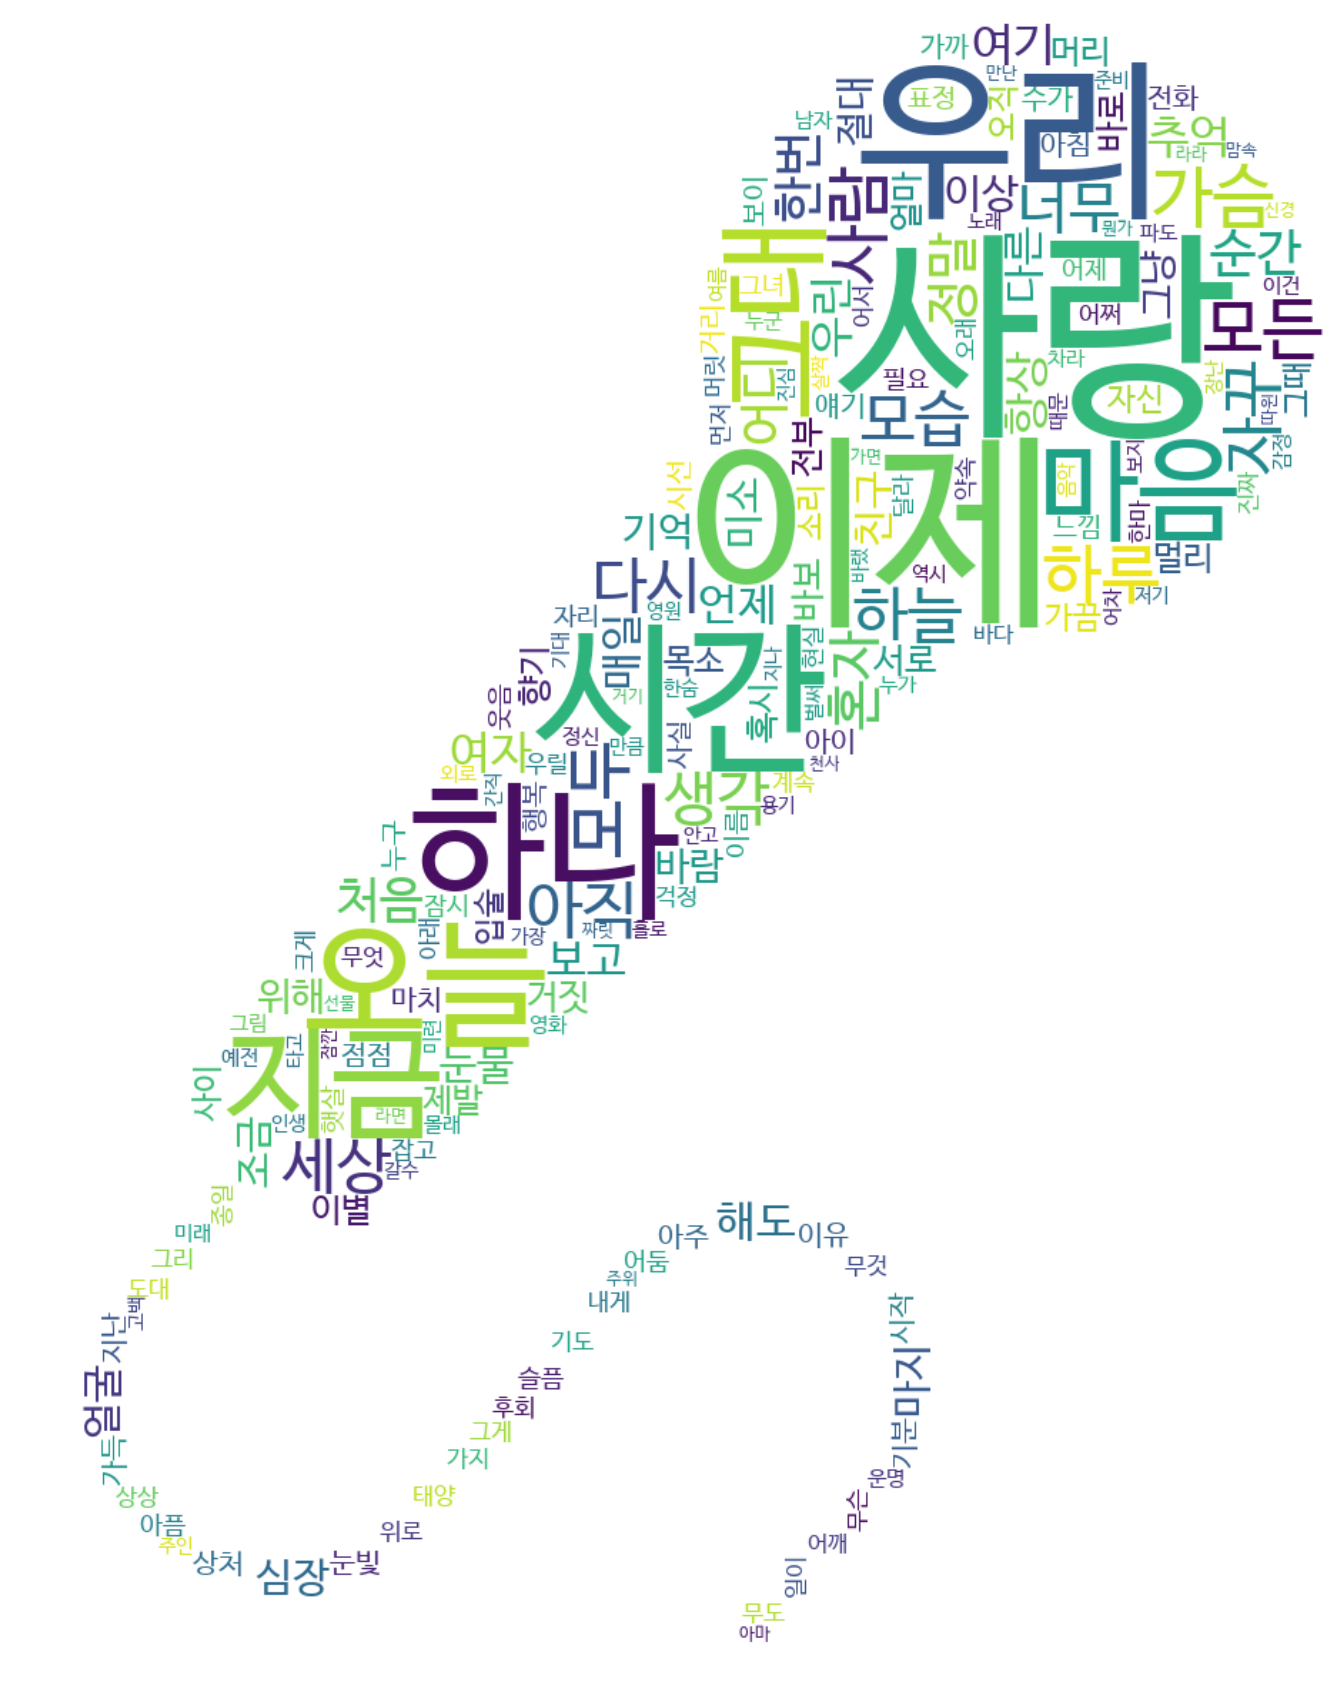

In [699]:
from PIL import Image
import numpy as np

alice_mask = np.array(Image.open("mic2.jpg"))

wordcloud = WordCloud(
    font_path = font_path,
    width = 1000,
    height = 1000,
    background_color="white",
    mask = alice_mask,
)

wordcloud = wordcloud.generate_from_frequencies(keywords)
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud,                                                                        interpolation="bilinear")
plt.axis("off")
plt.show()